# Authors: Gender Image classification Model


---



This notebook shows how to classify authors gender. It creates an image classifier using a `tf.keras.Sequential` model, and loads data using `tf.keras.utils.image_dataset_from_directory`. 

* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and dropout.

This notebook follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

## Import TensorFlow and other libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import zipfile
path_to_zip_file = "sample_data/images.zip"
directory_to_extract_to = "sample_data"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

## Download and explore the dataset

In [ ]:
import pathlib
data_dir = "sample_data/images"
data_dir = pathlib.Path(data_dir)

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

650


Here are some males:

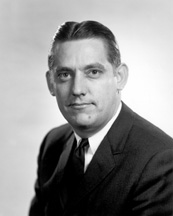

In [ ]:
male = list(data_dir.glob('male/*'))
PIL.Image.open(str(male[0]))

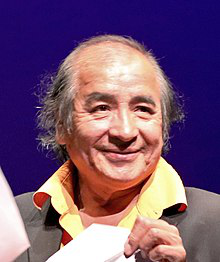

In [ ]:
PIL.Image.open(str(male[1]))

And some Females:

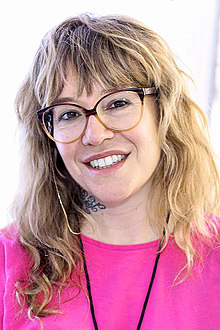

In [ ]:
female = list(data_dir.glob('female/*'))
PIL.Image.open(str(female[0]))

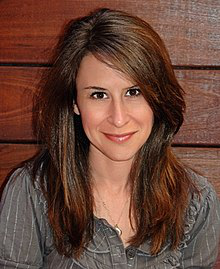

In [ ]:
PIL.Image.open(str(female[1]))

# Load data using a Keras utility
To load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take  directory of images on disk to a `tf.data.Dataset`.

## Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 64
img_height = 180
img_width = 180

It's good practice to use a validation split when developing model.
 80% of the images for training, and 20% for validation.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 748 files belonging to 2 classes.
Using 599 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 748 files belonging to 2 classes.
Using 149 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['female', 'male']


## Visualize the data

Here are the first nine images from the training dataset:

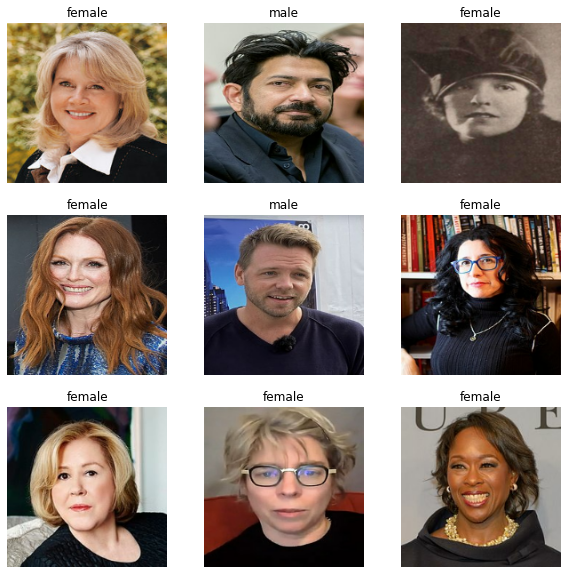

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 180, 180, 3)
(64,)


## Configure the dataset for performance

Use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


# Create the model

The Sequential model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`).

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the model

Choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model summary

View all the layers of the network using the model's `Model.summary` method:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

## Train the model

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
10/10 [==============================] - 13s 124ms/step - loss: 0.7039 - accuracy: 0.5576 - val_loss: 0.6823 - val_accuracy: 0.5101
Epoch 2/10
10/10 [==============================] - 1s 53ms/step - loss: 0.6597 - accuracy: 0.6027 - val_loss: 0.6229 - val_accuracy: 0.6376
Epoch 3/10
10/10 [==============================] - 0s 46ms/step - loss: 0.5659 - accuracy: 0.7112 - val_loss: 0.5914 - val_accuracy: 0.7047
Epoch 4/10
10/10 [==============================] - 0s 45ms/step - loss: 0.5166 - accuracy: 0.7179 - val_loss: 0.5422 - val_accuracy: 0.7450
Epoch 5/10
10/10 [==============================] - 0s 45ms/step - loss: 0.4451 - accuracy: 0.7796 - val_loss: 0.5411 - val_accuracy: 0.7248
Epoch 6/10
10/10 [==============================] - 0s 46ms/step - loss: 0.4448 - accuracy: 0.7963 - val_loss: 0.6430 - val_accuracy: 0.6913
Epoch 7/10
10/10 [==============================] - 0s 48ms/step - loss: 0.3759 - accuracy: 0.8214 - val_loss: 0.5238 - val_accuracy: 0.7517
Epoch 8/10


## Visualize training results

Create plots of loss and accuracy on the training and validation sets:

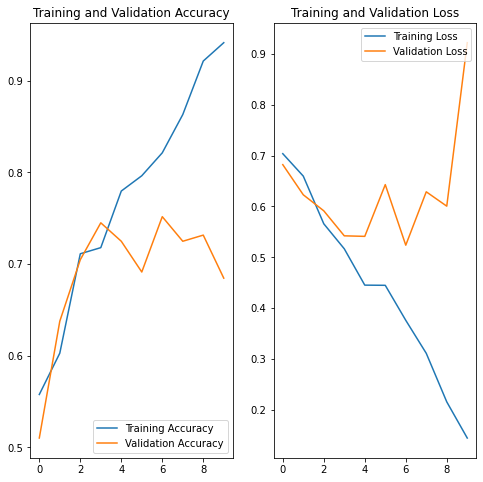

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 68% accuracy on the validation set.

Next step, inspect what went wrong and try to increase the overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of overfitting

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *Dropout* to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

I implemented data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

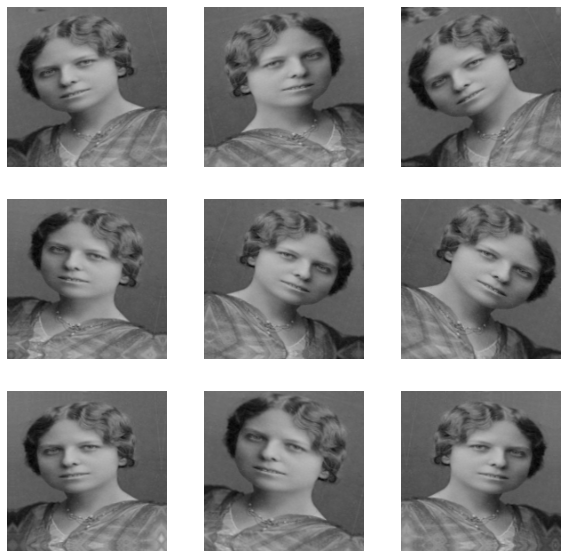

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will use data augmentation to train a model in a moment.

## Dropout

Another technique to reduce overfitting is to introduce dropout regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile and train the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_23 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_73 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_73 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_74 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_74 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
10/10 [==============================] - 1s 65ms/step - loss: 1.1835 - accuracy: 0.4841 - val_loss: 0.7044 - val_accuracy: 0.4765
Epoch 2/15
10/10 [==============================] - 0s 46ms/step - loss: 0.6898 - accuracy: 0.5292 - val_loss: 0.6794 - val_accuracy: 0.6443
Epoch 3/15
10/10 [==============================] - 0s 46ms/step - loss: 0.6747 - accuracy: 0.5793 - val_loss: 0.6651 - val_accuracy: 0.6309
Epoch 4/15
10/10 [==============================] - 0s 51ms/step - loss: 0.6124 - accuracy: 0.6778 - val_loss: 0.5900 - val_accuracy: 0.6779
Epoch 5/15
10/10 [==============================] - 0s 50ms/step - loss: 0.5560 - accuracy: 0.7095 - val_loss: 0.6017 - val_accuracy: 0.6980
Epoch 6/15
10/10 [==============================] - 0s 49ms/step - loss: 0.5473 - accuracy: 0.7229 - val_loss: 0.5392 - val_accuracy: 0.7248
Epoch 7/15
10/10 [==============================] - 0s 47ms/step - loss: 0.5494 - accuracy: 0.7312 - val_loss: 0.5370 - val_accuracy: 0.7584
Epoch 8/15
10

## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

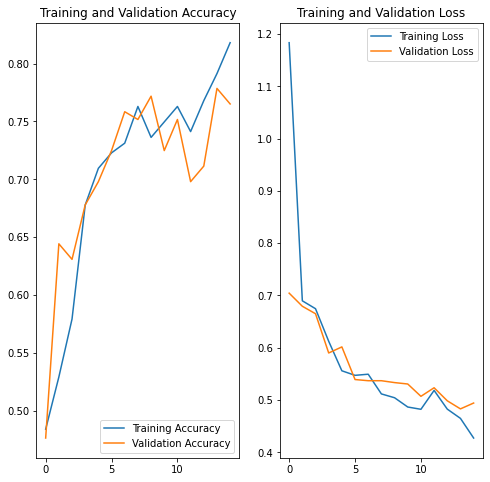

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

In [ ]:
path_to_test_zip_file = "sample_data/testingfemale.zip"
directory_to_extract_to_test = "sample_data"
with zipfile.ZipFile(path_to_test_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to_test)

In [ ]:
import os

arr = os.listdir('sample_data/testingfemale')
print(arr)

['Nora Johnson.jpg', 'Carolyn Haines.jpg', 'Jennifer Haigh.jpg', 'Libby Fischer Hellmann.jpg', 'Alma Katsu.jpg', 'Cynthia Kadohata.JPG', 'Karen Kondazian.jpg', 'A. M. Homes.jpg', 'A. S. King.jpg', 'Amelia Gray.jpg', 'Ann Herendeen.jpg', 'Paula Huston.jpg', 'Monique Raphel High.jpg', 'Elizabeth Kostova.jpg', 'Heidi Julavits.jpg', 'Nancy Hale.jpg']


In [ ]:
male_predictions = []
female_predictions = []
for img in arr:
  test_image_path = "sample_data/testingfemale/"+img
  img = tf.keras.utils.load_img(
      test_image_path, target_size=(img_height, img_width)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  if class_names[np.argmax(score)] == "male":
    male_predictions.append(img)
  else:
    female_predictions.append(img)
  print(
      "This image {} most likely belongs to {} with a {:.2f} percent confidence."
      .format(img,class_names[np.argmax(score)], 100 * np.max(score))
  )

print("=== Result ====")
print("Total Male Predictions in percentage = "+str((len(male_predictions)/len(arr) * 100)))
print("Total Female Predictions in percentage = "+str((len(female_predictions)/len(arr) * 100)))

This image <PIL.Image.Image image mode=RGB size=180x180 at 0x7F344E15CD90> most likely belongs to female with a 93.05 percent confidence.
This image <PIL.Image.Image image mode=RGB size=180x180 at 0x7F344E07ADD0> most likely belongs to female with a 72.72 percent confidence.
This image <PIL.Image.Image image mode=RGB size=180x180 at 0x7F344E08E890> most likely belongs to female with a 99.25 percent confidence.
This image <PIL.Image.Image image mode=RGB size=180x180 at 0x7F344DEF7690> most likely belongs to male with a 70.12 percent confidence.
This image <PIL.Image.Image image mode=RGB size=180x180 at 0x7F344DF6FB10> most likely belongs to female with a 99.36 percent confidence.
This image <PIL.Image.Image image mode=RGB size=180x180 at 0x7F344E021090> most likely belongs to female with a 98.87 percent confidence.
This image <PIL.Image.Image image mode=RGB size=180x180 at 0x7F344E016750> most likely belongs to female with a 98.67 percent confidence.
This image <PIL.Image.Image image mo

In [ ]:
path_to_test_zip_file = "sample_data/testingmale.zip"
directory_to_extract_to_test = "sample_data"
with zipfile.ZipFile(path_to_test_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to_test)

In [ ]:
arrm = os.listdir('sample_data/testingmale')
print(arrm)

['daniel-handler-1.jpg', 'dave-eggers-2.jpg', 'henry-valentine-miller.jpg', 'frank-skinner-1.jpg', 'dan-savage-1.jpg', 'mark-gatiss-1.jpg', 'mario-vargas-llosa-1.jpg', 'john-irving-3.jpg', 'steven-pinker-1.jpg', 'mark-levin-51825-1.jpg', 'david-ayer-1.jpg', 'john-le-carr.jpg', 'nassim-nicholas-taleb-1.jpg', 'joe-scarborough-1.jpg', 'douglas-brunt-1.jpg', 'alan-bennett.jpg', 'Official_portrait_of_Lord_Dobbs_crop_2,_2019.jpg', 'Steve_Brewer_(2259789298).jpg', 'dan-simmons-1.jpg', 'orson-bean-1.jpg', 'henry-rollins-3.jpg']


In [ ]:
nmale_predictions = []
nfemale_predictions = []
for img in arrm:
  test_image_path = "sample_data/testingmale/"+img
  img = tf.keras.utils.load_img(
      test_image_path, target_size=(img_height, img_width)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  if class_names[np.argmax(score)] == "female":
    nfemale_predictions.append(img)
  else:
    nmale_predictions.append(img)
  print(
      "This image {} most likely belongs to {} with a {:.2f} percent confidence."
      .format(img,class_names[np.argmax(score)], 100 * np.max(score))
  )

print("=== Result ====")
print("Total female Predictions in percentage = "+str((len(nfemale_predictions)/len(arrm) * 100)))
print("Total male Predictions in percentage = "+str((len(nmale_predictions)/len(arrm) * 100)))

This image <PIL.Image.Image image mode=RGB size=180x180 at 0x7F344DFB1610> most likely belongs to male with a 92.20 percent confidence.
This image <PIL.Image.Image image mode=RGB size=180x180 at 0x7F344C7459D0> most likely belongs to male with a 78.04 percent confidence.
This image <PIL.Image.Image image mode=RGB size=180x180 at 0x7F344D538CD0> most likely belongs to female with a 75.94 percent confidence.
This image <PIL.Image.Image image mode=RGB size=180x180 at 0x7F344C745690> most likely belongs to male with a 87.72 percent confidence.
This image <PIL.Image.Image image mode=RGB size=180x180 at 0x7F3466094B10> most likely belongs to male with a 70.47 percent confidence.
This image <PIL.Image.Image image mode=RGB size=180x180 at 0x7F344E093050> most likely belongs to male with a 54.16 percent confidence.
This image <PIL.Image.Image image mode=RGB size=180x180 at 0x7F344E093610> most likely belongs to male with a 86.48 percent confidence.
This image <PIL.Image.Image image mode=RGB siz